In [1]:
import os
import numpy as np
import pandas as pd
import bambi
from PIL import Image
from tqdm import tqdm
from scipy.stats import spearmanr
import pymc3 as pm
import arviz as az

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

from utils.stats import get_var
from utils.plotting import despine, cm2inch
from utils.general import make_sure_path_exists
from utils.descriptives import compute_gaze_influence_score

# Descriptives & data

In [2]:
# directories 
data_dir = '../data/'
mfx_dir = '../results/posterior_traces/regression_models/'
figure_dir = '../figures/'

# make sure output dirs exist
make_sure_path_exists(figure_dir)
make_sure_path_exists(mfx_dir)

# set sizes
setsizes = np.array([9, 16, 25, 36])

# load response data
data = []
for setsize in setsizes:
    df_setsize = pd.read_csv(data_dir+'summary_files/setsize-{}_desc-data.csv'.format(setsize))
    df_setsize['setsize'] = setsize
    data.append(df_setsize)
data = pd.concat(data, sort=True)
data.head()

# subjects
subjects = np.sort(data.subject.unique())
n_subjects = subjects.size

# load gaze data
gaze_data = []
for subject in subjects:
    for c in setsizes:
        tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
        gaze_data.append(tmp_data)
gaze_data = pd.concat(gaze_data, sort=True)

In [3]:
data.head()

,best_chosen,best_seen_chosen,choice,cumulative_gaze_0,cumulative_gaze_1,cumulative_gaze_10,cumulative_gaze_11,cumulative_gaze_12,cumulative_gaze_13,cumulative_gaze_14,...,stimulus_34,stimulus_35,stimulus_4,stimulus_5,stimulus_6,stimulus_7,stimulus_8,stimulus_9,subject,trial
0,1.0,1.0,1,0.072271,0.153518,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr62.png,nr125.png,nr63.png,nr113.png,nr27.png,NaN,0,2
1,1.0,1.0,0,0.074341,0.073074,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr76.png,nr93.png,nr79.png,nr4.png,nr92.png,NaN,0,3
2,1.0,1.0,1,0.068776,0.124769,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr56.png,nr91.png,nr30.png,nr106.png,nr121.png,NaN,0,7
3,1.0,1.0,3,0.133512,0.060818,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr21.png,nr85.png,nr2.png,nr58.png,nr7.png,NaN,0,9
4,1.0,1.0,4,0.060270,0.072763,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nr69.png,nr81.png,nr79.png,nr58.png,nr28.png,NaN,0,14


In [4]:
gaze_data.head()

,choice,dur,gaze_num,is_first,is_last,is_last_to_choice,is_returning,item,item_value,onset,returning_gaze_count,setsize,stimulus,subject,trial
0,1,552.0,1.0,1.0,0.0,1.0,0.0,4,0.0,76.0,0.0,9,nr62.png,0,2
1,1,188.0,2.0,0.0,0.0,1.0,0.0,3,0.0,678.0,0.0,9,nr48.png,0,2
2,1,260.0,3.0,0.0,0.0,1.0,0.0,7,0.0,922.0,0.0,9,nr113.png,0,2
3,1,348.0,4.0,0.0,0.0,1.0,0.0,1,2.0,1238.0,0.0,9,nr10.png,0,2
4,1,326.0,5.0,0.0,0.0,1.0,0.0,0,0.0,1662.0,0.0,9,nr91.png,0,2


## Insert additional item attributes

### "Size" 

In [5]:
def compute_item_sizes(stimulus_images, rgb_threshold=5):
    """Compute the fraction of an image that is not black
    (ie. the snack food item). This function assumes that 
    the image background is consistently black.
    
    Args:
        stimulus_images (array): paths to stimulus images 
            for which size is to be computed
        rgb_threshold (int): defines the maximum value of
            any rgb-index that is still counted as black;
            if rgb_threshold = 5 all rgb-indeces must be < 5
                 
    Returns:
        array containing sizes for each stimulus image
    """
    # compute sizes of items, relative to image size
    relative_item_sizes = dict()
    for stimulus_image in stimulus_images:

        # load image
        im = Image.open(stimulus_image)
        colors = im.getcolors(im.size[0]*im.size[1])
        num_pixels = float(im.size[0]*im.size[1])
        num_black_pixels = np.sum([s[0] for s in colors
                                   if np.all(np.array(s[1][:-1]) < rgb_threshold)])
        fraction_item = 1. - (num_black_pixels/num_pixels)
        relative_item_sizes[stimulus_image] = fraction_item

    return relative_item_sizes

In [6]:
# load image paths
image_dir = data_dir+'stimuli/'
stimulus_images = np.sort([image_dir+s for s in os.listdir(image_dir) if s.endswith('.png')])

# compute image sizes
item_sizes = compute_item_sizes(stimulus_images)

# add sizes to data
trial_stimuli = data[['stimulus_{}'.format(i)
                      for i in range(np.max(setsizes))]].values
trial_stimulus_sizes = np.array([item_sizes[image_dir+stimulus]
                                 if str(stimulus) != 'nan' else np.nan
                                 for stimulus in trial_stimuli.ravel()])
trial_stimulus_sizes = trial_stimulus_sizes.reshape(trial_stimuli.shape)
for i in range(np.max(setsizes)):
    data['item_size_{}'.format(i)] = trial_stimulus_sizes[:,i]

### "Row" and "column" positions

In [7]:
def return_row_col_pairs(setsize):
    out = []
    for row in range(np.int(np.sqrt(setsize))):
        for col in range(np.int(np.sqrt(setsize))):
            out.append((row+1, col+1)) # we start indexing at 1
    return out      

In [8]:
from itertools import combinations_with_replacement
position_mapping = dict()
for setsize in setsizes:
    position_mapping[setsize] = return_row_col_pairs(setsize)
print(position_mapping)

{9: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 16: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)], 25: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)], 36: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]}


In [9]:
for setsize in setsizes:
    for i in range(setsize):
        data.loc[data['setsize']==setsize, 'item_row_{}'.format(i)] = position_mapping[setsize][i][0]
        data.loc[data['setsize']==setsize, 'item_column_{}'.format(i)] = position_mapping[setsize][i][1]

## individual regression: $cumulative\_gaze \sim row + column + size + rating + setsize$

In [10]:
mfx_coef = np.zeros((n_subjects, 4))
for subject in subjects:
    
    print('\nProcessing subject: {}'.format(subject))
    sub_data = data[data['subject']==subject].copy()
    
    # extract predictors
    cumulative_gaze = []
    rows = []
    columns = []
    ratings = []
    sizes = []
    _setsizes = []
    for setsize in setsizes:
        setsize_data = sub_data[sub_data['setsize']==setsize].copy()
        cumulative_gaze.append(setsize_data[['cumulative_gaze_{}'.format(i) for i in range(setsize)]].values.ravel())
        rows.append(setsize_data[['item_row_{}'.format(i) for i in range(setsize)]].values.ravel())
        columns.append(setsize_data[['item_column_{}'.format(i) for i in range(setsize)]].values.ravel())
        ratings.append(setsize_data[['item_value_{}'.format(i) for i in range(setsize)]].values.ravel())
        sizes.append(setsize_data[['item_size_{}'.format(i) for i in range(setsize)]].values.ravel())
        _setsizes.append(setsize*np.ones(sizes[-1].size))
    
    # merge
    mfx_df = pd.DataFrame({'setsize': np.concatenate(_setsizes),
                           'cumulative_gaze': np.concatenate(cumulative_gaze) * 100,
                           'row': np.concatenate(rows),
                           'column': np.concatenate(columns),
                           'size': np.concatenate(sizes) * 100,
                           'rating': np.concatenate(ratings)})
    
    # fit model
    np.random.seed(subject+1)
    n_samples = 2000
    burn = 500
    out_path = mfx_dir+'cumulative-gaze_item-attributes_subject-{}'.format(subject)
    if not os.path.isfile(out_path+'.csv'):
        # set up model
        model = bambi.Model(data=mfx_df.copy())
        # add fixed effects
        model.add('cumulative_gaze ~ row + column + size + rating + setsize')
        # sample posterior
        results = model.fit(samples=n_samples,
                            tune=burn,
                            family='bernoulli',
                            chains=2,
                            backend='pymc',
                            init='ADVI',
                            n_init=50000, 
                            random_seed=[subject+1, subject+10])
        # save results
        az.plot_trace(results)
        plt.savefig(out_path+'.png', dpi=220)
        plt.show()
        summary = az.summary(results)
        summary.to_csv(out_path+'.csv')
    else:
        print('Loading pre-computed posterior trace from '+mfx_dir)
        summary = pd.read_csv(out_path+'.csv', index_col='Unnamed: 0')

    # extract coefficient estimates
    for vari, var in enumerate(['row', 'column', 'size', 'rating']):
        mean, _ = get_var(summary, var+'[0]')
        mfx_coef[subject, vari] = mean


Processing subject: 0
Loading pre-computed posterior trace from ../results/posterior_traces/regression_models/
row[0]; Mean: -0.133, 94% HPD: -0.209, -0.057
column[0]; Mean: 0.057, 94% HPD: -0.018000000000000002, 0.13699999999999998
size[0]; Mean: 0.039, 94% HPD: 0.031, 0.048
rating[0]; Mean: 0.785, 94% HPD: 0.677, 0.898

Processing subject: 1
Loading pre-computed posterior trace from ../results/posterior_traces/regression_models/
row[0]; Mean: -0.114, 94% HPD: -0.203, -0.035
column[0]; Mean: 0.112, 94% HPD: 0.028, 0.195
size[0]; Mean: 0.035, 94% HPD: 0.026, 0.045
rating[0]; Mean: 0.391, 94% HPD: 0.263, 0.505

Processing subject: 2
Loading pre-computed posterior trace from ../results/posterior_traces/regression_models/
row[0]; Mean: -0.401, 94% HPD: -0.508, -0.28600000000000003
column[0]; Mean: -0.21600000000000005, 94% HPD: -0.332, -0.101
size[0]; Mean: 0.042, 94% HPD: 0.029, 0.055
rating[0]; Mean: 0.622, 94% HPD: 0.528, 0.72

Processing subject: 3
Loading pre-computed posterior trac

row[0]; Mean: 0.013, 94% HPD: -0.064, 0.092
column[0]; Mean: -0.085, 94% HPD: -0.16, -0.01
size[0]; Mean: 0.008, 94% HPD: -0.0, 0.016
rating[0]; Mean: 0.254, 94% HPD: 0.18600000000000005, 0.319

Processing subject: 32
Loading pre-computed posterior trace from ../results/posterior_traces/regression_models/
row[0]; Mean: -0.307, 94% HPD: -0.405, -0.206
column[0]; Mean: -0.12, 94% HPD: -0.22, -0.018000000000000002
size[0]; Mean: 0.03, 94% HPD: 0.019, 0.041
rating[0]; Mean: 0.47, 94% HPD: 0.397, 0.539

Processing subject: 33
Loading pre-computed posterior trace from ../results/posterior_traces/regression_models/
row[0]; Mean: -0.551, 94% HPD: -0.753, -0.379
column[0]; Mean: 0.01, 94% HPD: -0.175, 0.175
size[0]; Mean: 0.039, 94% HPD: 0.019, 0.058
rating[0]; Mean: 0.57, 94% HPD: 0.401, 0.7490000000000001

Processing subject: 34
Loading pre-computed posterior trace from ../results/posterior_traces/regression_models/
row[0]; Mean: 0.281, 94% HPD: 0.159, 0.401
column[0]; Mean: 0.026, 94% HPD: -

# Compute choice psychometrics from Figure 4 A-E

In [11]:
np.random.seed(12321)

# 1. % seen items count vs set-size
data['seen_items_count_fraction'] = (data['seen_items_count'] / data['setsize']).values
sub_frac_items_seen = np.concatenate(
    [data.groupby(['setsize', 'subject']).seen_items_count_fraction.mean()[s][:,None]
     for s in setsizes], axis=1) * 100

# 2. Response time vs set-size
data['rt_s'] = data['rt'].values / 1000.
sub_rt_means = np.concatenate([data.groupby(['setsize', 'subject']).rt_s.mean()[s][:,None]
                               for s in setsizes], axis=1)

# 3. P(choose best seen item )
sub_best_seen_chosen_means = np.concatenate(
    [data.groupby(['setsize','subject']).best_seen_chosen.mean()[s][:,None]
     for s in setsizes], axis=1) * 100
    
# 4. P(last gaze to choice)
sub_last_gaze_to_choice_means = np.concatenate(
    [gaze_data.groupby(['setsize', 'subject', 'trial']).tail(1).groupby(
        ['setsize', 'subject']).is_last_to_choice.mean()[s][:,None]
     for s in setsizes], axis=1) * 100

# 5. Gaze Influence on choice probability
sub_gaze_influence_scores = []
for setsize in setsizes:
    sub_gaze_influence_scores.append(compute_gaze_influence_score(data[data['setsize']==setsize].copy())[:,None])
sub_gaze_influence_scores = np.concatenate(sub_gaze_influence_scores, axis=1)

/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/miniconda3/envs/GLAM/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will

# Figure 4-figure supplement 2

In [12]:
def _scatter(x, y, ax, color, label=None):
    """nice scatters"""
    ax.scatter(x, y, marker='o', color='none', edgecolor=color, 
               linewidth=0.75, alpha=1, s=20)
    ax.scatter(x, y, marker='o', color=color, alpha=0.2,
               linewidth=0, s=20, label=label)

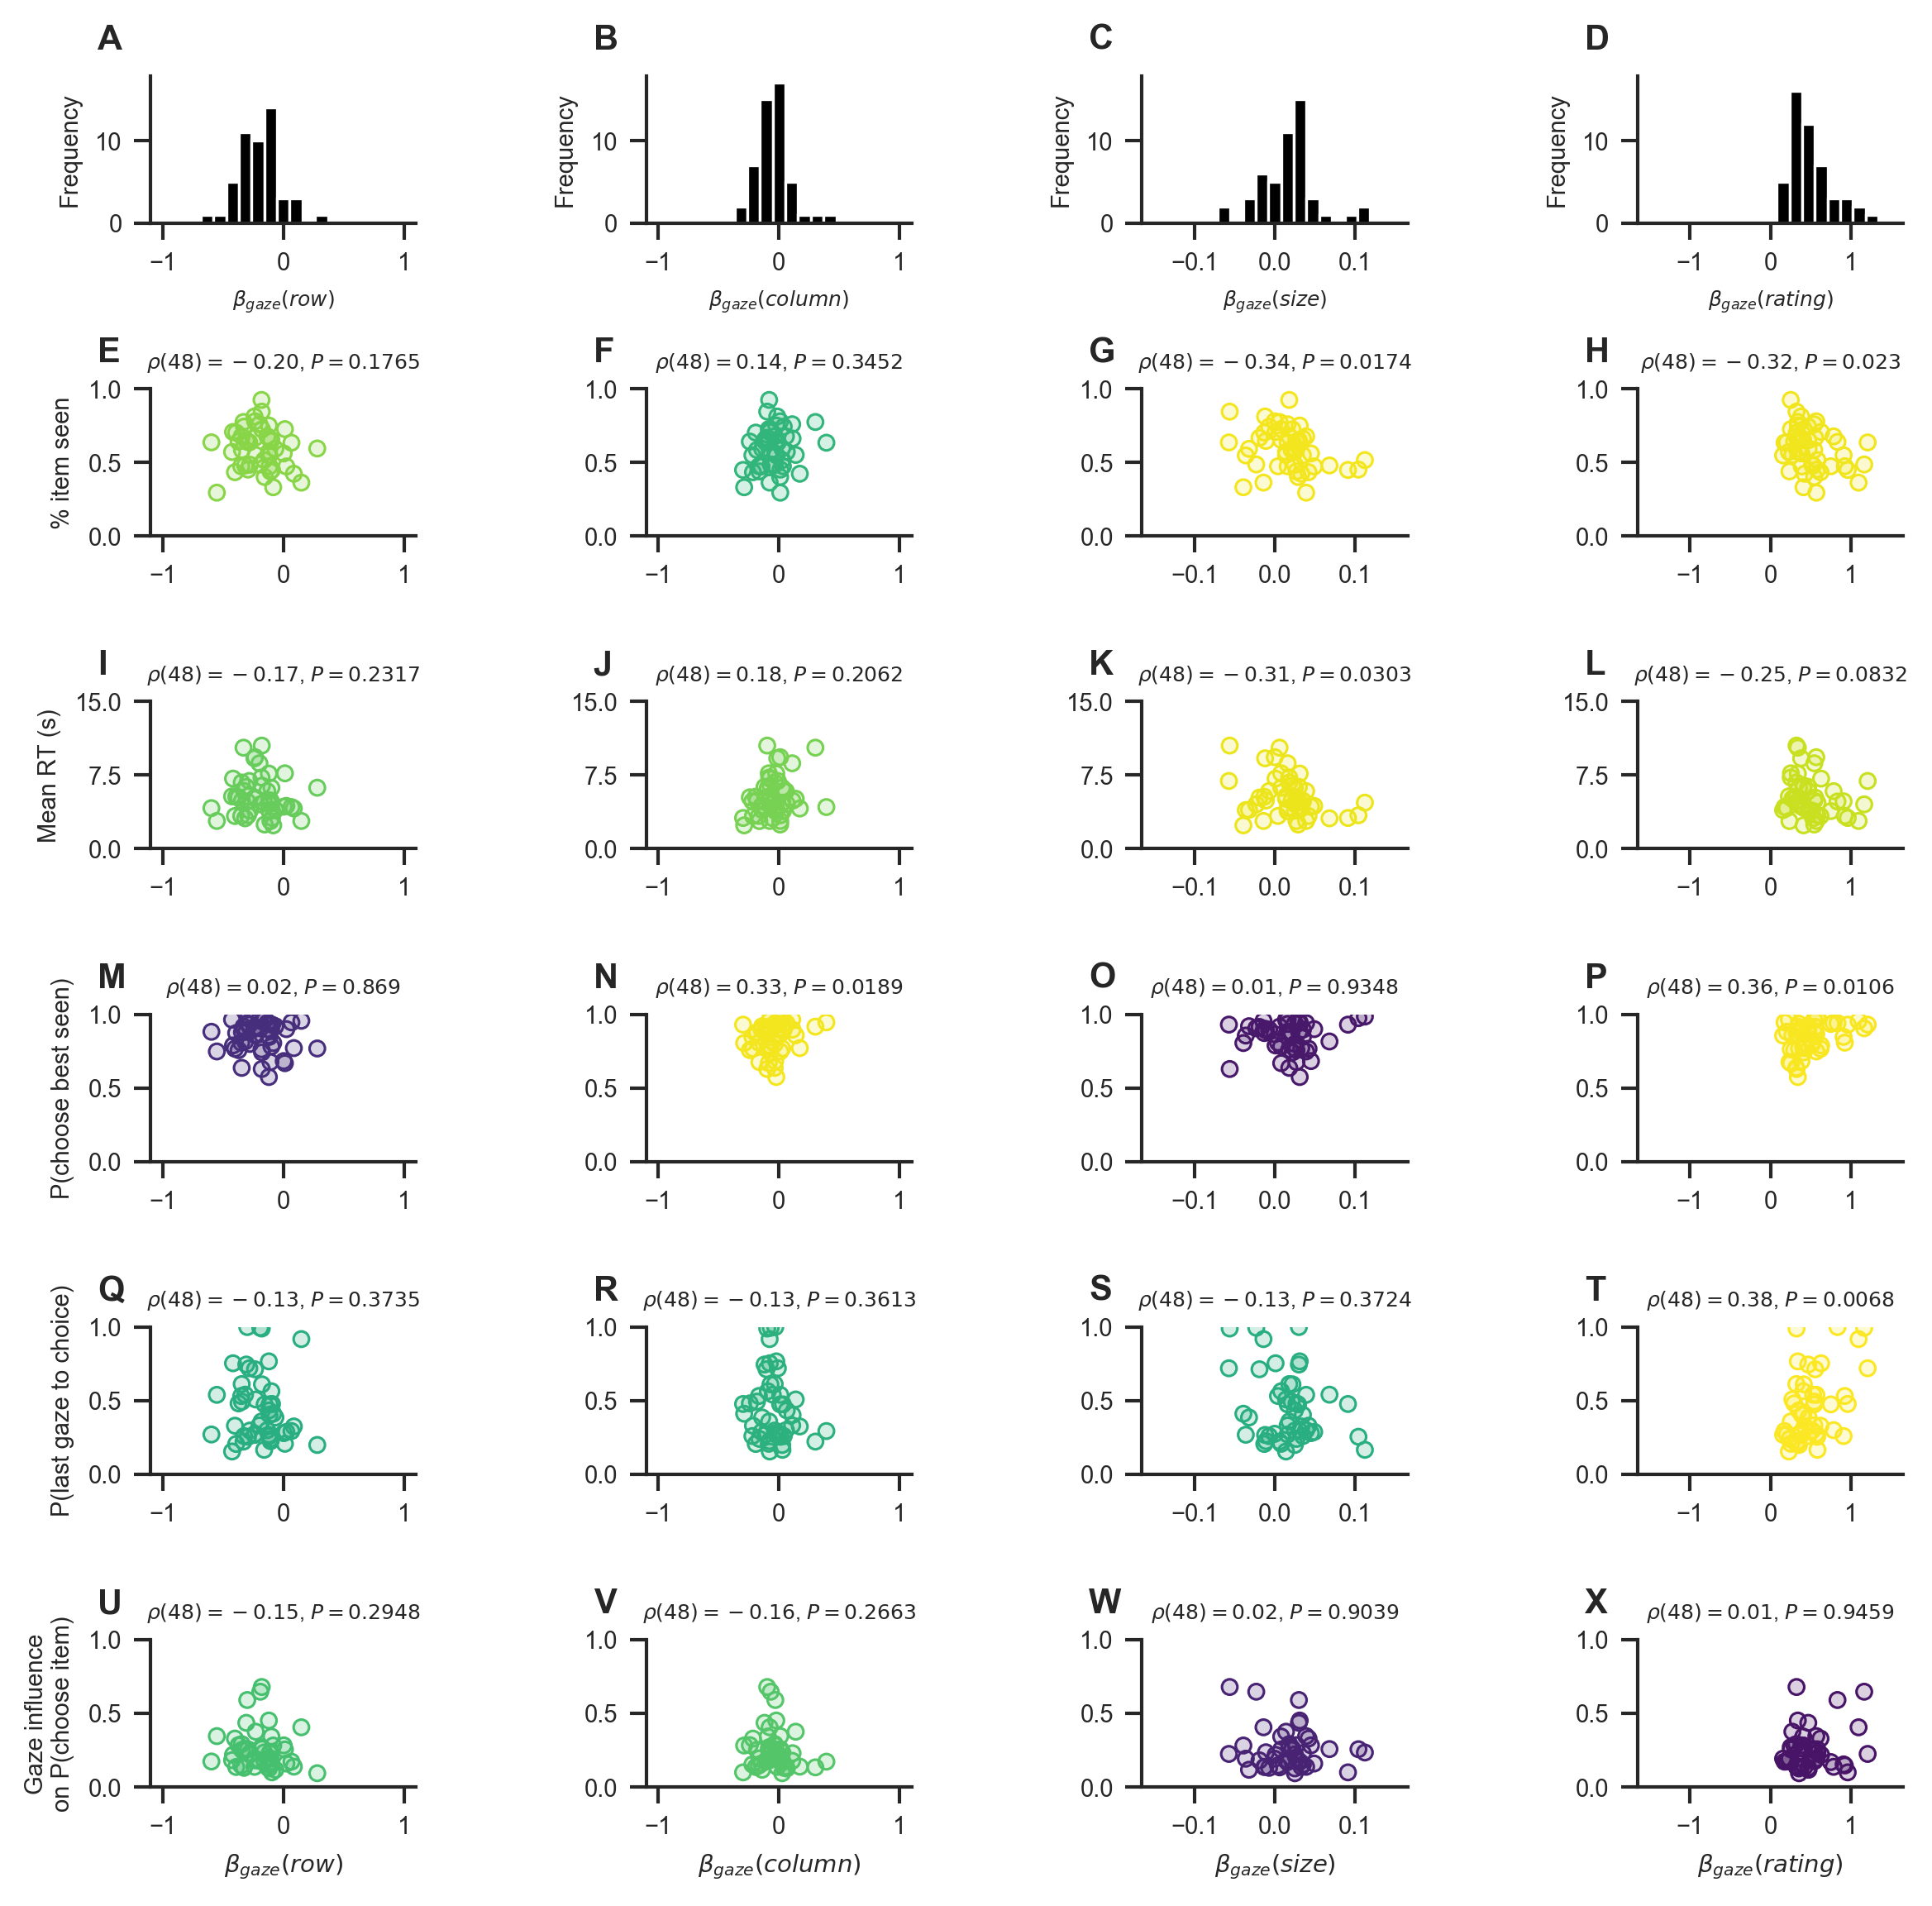

In [13]:
np.random.seed(1248)

fig, axs = plt.subplots(6, 4, figsize=cm2inch(20,20), dpi=300, sharex='col', sharey='row')

# histograms: gaze
axs[0,0].set_xlabel(r'$\beta_{gaze}(row)$', fontsize=6)
axs[0,0].hist(mfx_coef[:,0], bins=np.linspace(-1,1, 20), color='k')
axs[0,1].set_xlabel(r'$\beta_{gaze}(column)$', fontsize=6)
axs[0,1].hist(mfx_coef[:,1], bins=np.linspace(-1,1, 20), color='k')
axs[0,2].set_xlabel(r'$\beta_{gaze}(size)$', fontsize=6)
axs[0,2].hist(mfx_coef[:,2], bins=np.linspace(-0.15,0.15, 20), color='k')
axs[0,3].set_xlabel(r'$\beta_{gaze}(rating)$', fontsize=6)
axs[0,3].hist(mfx_coef[:,3], bins=np.linspace(-1.5,1.5, 20), color='k')
for ax in axs[0]:
    despine(ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_ylabel('Frequency', fontsize=7)
    
# iterate over choice variables
for ci, (c_var_label, c_var) in enumerate(zip(['% item seen',
                                               'Mean RT (s)',
                                               'P(choose best seen)',
                                               'P(last gaze to choice)',
                                               'Gaze influence\non P(choose item)'],
                                             [sub_frac_items_seen.mean(axis=1) / 100.,
                                              sub_rt_means.mean(axis=1),
                                              sub_best_seen_chosen_means.mean(axis=1) / 100.,
                                              sub_last_gaze_to_choice_means.mean(axis=1) / 100.,
                                              sub_gaze_influence_scores.mean(axis=1)])):
    
    # iterate over search metrics
    for si, (s_var_label, s_var) in enumerate(zip([r'$\beta_{gaze}(row)$', r'$\beta_{gaze}(column)$',
                                                   r'$\beta_{gaze}(size)$', r'$\beta_{gaze}(rating)$'],
                                                  [mfx_coef[:,0], mfx_coef[:,1],
                                                   mfx_coef[:,2], mfx_coef[:,3]])):
        
        # annotate
        rval, pval = spearmanr(s_var, c_var)
        if pval < 0.0001:
            p_string = r'$P < 0.0001$'
        else:
            p_string = r'$P = {}$'.format(np.round(pval, 4))
        annotation = (r'$\rho(48) = {:.2f}$, '.format(rval)) + p_string        
        
        # scatter
        _scatter(s_var, c_var, ax=axs[ci+1, si],
                 color=cm.viridis(1-pval))
        axs[ci+1, si].set_title(annotation, fontsize=6)
        if si == 0:
            axs[ci+1,si].set_ylabel(c_var_label, fontsize=7)
        if ci+1 == 5: 
            axs[ci+1,si].set_xlabel(s_var_label, fontsize=7)
        despine(ax=axs[ci+1,si])
        axs[ci+1,si].tick_params(axis='both', which='major', labelsize=7)
        if not 'RT' in c_var_label:
            axs[ci+1,si].set_yticks([0, 0.5, 1])
            axs[ci+1,si].set_ylim([0, 1])
        else:
            axs[ci+1,si].set_yticks([0, 7.5, 15])
            axs[ci+1,si].set_ylim([0, 15])


for ax, label in zip(axs.ravel(), list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')):
    ax.text(-0.2, 1.35, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')

    
fig.tight_layout(w_pad=4, h_pad=0)

fig.savefig(figure_dir+'Figure-4-figure-supplement-2_association-search-choice.pdf', dpi=300)
fig.savefig(figure_dir+'Figure-4-figure-supplement-2_association-search-choice.png', dpi=300)
fig.savefig(figure_dir+'Figure-4-figure-supplement-2_association-search-choice.jpg', dpi=300)

# Estimate regression model for each association

In [14]:
seed = 198

# iterate over choice metrics
for ci, (c_var_label, c_var) in enumerate(zip(['frac_items_seen',
                                               'RT',
                                               'p_choose_best_seen',
                                               'p_choose_last_seen',
                                               'gaze_influence'],
                                             [sub_frac_items_seen.mean(axis=1),
                                              sub_rt_means.mean(axis=1),
                                              sub_best_seen_chosen_means.mean(axis=1),
                                              sub_last_gaze_to_choice_means.mean(axis=1),
                                              sub_gaze_influence_scores.mean(axis=1)])):
    
    # iterate over search metrics
    for si, (s_var_label, s_var) in enumerate(zip(['beta_row', 'beta_col',
                                                   'beta_size', 'beta_rating'],
                                                  [mfx_coef[:,0], mfx_coef[:,1],
                                                   mfx_coef[:,2], mfx_coef[:,3]])):
                
        print('\n\nComputing: {} ~ {}'.format('-'.join(c_var_label.split('_')),
                                              '-'.join(s_var_label.split('_'))))
        mfx_filename = '{}_{}_mfx'.format('-'.join(c_var_label.split('_')), '-'.join(s_var_label.split('_')))
        if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):

            # make model
            samples = 2000
            burn = 500
            model = bambi.Model(data=pd.DataFrame({s_var_label: s_var,
                                                   c_var_label: c_var}))
            model.add('{} ~ {}'.format(c_var_label, s_var_label))

            # sample posterior
            results = model.fit(samples=samples,
                                tune=burn,
                                chains=2,
                                backend='pymc',
                                init='ADVI',
                                n_init=50000,
                                random_seed=seed)

            # save results
            pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
            az.plot_trace(results)
            plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
            summary = az.summary(results, round_to='none')
            summary.to_csv(mfx_dir+mfx_filename+'.csv')

        else:
            print('Loading mfx-summary from '+mfx_dir)
            summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

        _ = get_var(summary, 'Intercept[0]')
        _ = get_var(summary, '{}[0]'.format(s_var_label))

        seed += 1



Computing: frac-items-seen ~ beta-row
Loading mfx-summary from ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 57.94325714146722, 94% HPD: 52.403722390809705, 63.068069511263886
beta_row[0]; Mean: -8.13672857924428, 94% HPD: -28.69856266560806, 12.162340344461446


Computing: frac-items-seen ~ beta-col
Loading mfx-summary from ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 60.420102708640435, 94% HPD: 57.015381031884864, 64.2057956213795
beta_col[0]; Mean: 20.949158383738755, 94% HPD: -4.678506782020537, 47.12696867044486


Computing: frac-items-seen ~ beta-size
Loading mfx-summary from ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 61.42682475644626, 94% HPD: 57.64627031538354, 65.34894677192386
beta_size[0]; Mean: -112.51696479345014, 94% HPD: -209.6261468495241, -6.171036965901092


Computing: frac-items-seen ~ beta-rating
Loading mfx-summary from ../results/posterior_traces/regression_models/
Intercept[0]; Mean: 67.957736